In [1]:
!pip -q install -U accelerate evaluate sacrebleu nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 498.5 kB/s eta 0:00:000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s et

In [2]:
pip install -U --upgrade transformers peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 86.0 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.9/504.9 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 60.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
  Attempting uninstall: peft
    Found existin

In [3]:
import os, random
import numpy as np
import torch
import nltk
import evaluate
from datasets import load_dataset, DatasetDict
from transformers import (
    TrainingArguments, Trainer,
    BlipProcessor, BlipForConditionalGeneration,
    AutoProcessor, AutoTokenizer, AutoFeatureExtractor,
    GitProcessor, GitForCausalLM,
    VisionEncoderDecoderModel
)

nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

2025-10-03 23:10:16.736895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759533016.920174      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759533016.975127      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
try:
    ds
except NameError:
    HF_TOKEN = os.getenv("HUGGINGFACE_HUB_TOKEN", None)
    DS_ID = "itsanmolgupta/mimic-cxr-dataset"
    ds = load_dataset(DS_ID, token=HF_TOKEN)
    if "test" not in ds:
        if "validation" in ds:
            n_train, n_val = len(ds["train"]), len(ds["validation"])
            total = n_train + n_val
            desired_test = max(1, int(round(0.10 * total)))
            test_ratio = min(0.5, desired_test / n_train)
            split = ds["train"].train_test_split(test_size=test_ratio, seed=42, shuffle=True)
            ds = DatasetDict(train=split["train"], validation=ds["validation"], test=split["test"])
        else:
            tmp = ds["train"].train_test_split(test_size=0.2, seed=42)
            vt = tmp["test"].train_test_split(test_size=0.5, seed=42)
            ds = DatasetDict(train=tmp["train"], validation=vt["train"], test=vt["test"])

# Keep only needed cols and filter missing findings
def has_findings(x):
    f = x.get("findings", None)
    return f is not None and isinstance(f, str) and len(f.strip()) > 0

ds = ds.filter(has_findings)
print("Sizes:", {k: len(v) for k,v in ds.items()})

README.md:   0%|          | 0.00/357 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/396M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/397M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/30633 [00:00<?, ? examples/s]

Filter:   0%|          | 0/24506 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3063 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3064 [00:00<?, ? examples/s]

Sizes: {'train': 24506, 'validation': 3063, 'test': 3064}


In [5]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=690b4a7fbada2da649257ab524c31083f554e703ea814e6a8f573c3051b3c7d0
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [6]:
rouge = evaluate.load("rouge")
bleu  = evaluate.load("bleu")
meteor = evaluate.load("meteor")

def normalize_text(text: str) -> str:
    return " ".join((text or "").strip().split())

def compute_text_metrics(preds, refs):
    preds = [normalize_text(p) for p in preds]
    refs  = [normalize_text(r) for r in refs]
    r = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    b = bleu.compute(predictions=preds, references=[[x] for x in refs])
    m = meteor.compute(predictions=preds, references=refs)
    return {"rouge1": r["rouge1"], "rouge2": r["rouge2"], "rougeL": r["rougeL"], "bleu": b["bleu"], "meteor": m["meteor"]}

def batched_image_to_text(pipe, images, batch_size=4, **gen_kwargs):
    preds = []
    for i in range(0, len(images), batch_size):
        out = pipe(images[i:i+batch_size], **gen_kwargs)
        if isinstance(out[0], dict) and "generated_text" in out[0]:
            preds.extend(normalize_text(x["generated_text"]) for x in out)
        else:
            preds.extend(normalize_text(x[0]["generated_text"]) for x in out)
    return preds

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
import os
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer

# ---- Patched BLIP to drop unsupported kwargs ----
class PatchedBlip(BlipForConditionalGeneration):
    def forward(self, *args, **kwargs):
        # Drop the unsupported kwarg injected by Trainer
        kwargs.pop("num_items_in_batch", None)
        return super().forward(*args, **kwargs)

# --- Hyperparameters ---
blip_hp = dict(
    model_id="Salesforce/blip-image-captioning-base",
    output_dir="outputs/blip_findings",
    lr=5e-5,
    epochs=2,           # set to 2 to reduce training time
    train_bsz=8,
    eval_bsz=8,
    grad_accum=2,
    max_target_len=96,
)

# --- Processor & Model ---
blip_processor = BlipProcessor.from_pretrained(blip_hp["model_id"], use_fast=True)
blip_model = PatchedBlip.from_pretrained(blip_hp["model_id"])

# --- Collator ---
class BlipCollator:
    def __init__(self, processor, max_target_len):
        self.processor = processor
        self.max_target_len = max_target_len

    def __call__(self, features):
        images = [f["image"] for f in features]
        texts  = [f["findings"] for f in features]

        enc = self.processor(
            images=images,
            text=texts,
            padding="max_length",
            truncation=True,
            max_length=self.max_target_len,
            return_tensors="pt"
        )

        # Prepare labels (ignore padding tokens)
        labels = enc["input_ids"].clone()
        labels[enc["attention_mask"] == 0] = -100

        return {
            "pixel_values": enc["pixel_values"],
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": labels,
        }

blip_collator = BlipCollator(blip_processor, blip_hp["max_target_len"])

# --- Dataset filtering (keep only 'image' + 'findings') ---
train_ds = ds["train"].remove_columns([c for c in ds["train"].column_names if c not in ["image", "findings"]])
eval_split = "validation" if "validation" in ds else "test"
eval_ds_ = ds[eval_split].remove_columns([c for c in ds[eval_split].column_names if c not in ["image", "findings"]])

# --- Precision setup (bf16 if Ampere+, else fp16) ---
use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [9]:
import os
from transformers import BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer
import torch

# Make sure output directory exists
os.makedirs(blip_hp["output_dir"], exist_ok=True)
print(f"Output directory is ready: {blip_hp['output_dir']}")

# --- Checkpoint management ---
def get_latest_checkpoint(output_dir):
    """Return the path to the latest checkpoint if exists, else None."""
    if not os.path.exists(output_dir):
        return None
    checkpoints = [d for d in os.listdir(output_dir) if d.startswith("checkpoint")]
    if not checkpoints:
        return None
    latest_ckpt = sorted(checkpoints, key=lambda x: int(x.split('-')[1]))[-1]
    return os.path.join(output_dir, latest_ckpt)

resume_ckpt = get_latest_checkpoint(blip_hp["output_dir"])
if resume_ckpt:
    print(f"Found checkpoint, will resume from: {resume_ckpt}")
else:
    print("No checkpoint found, starting training from scratch.")

# --- Training arguments ---
# Use bf16 if available (A100, H100), otherwise fp16
use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8

# --- Training arguments ---
args = TrainingArguments(
    output_dir=blip_hp["output_dir"],
    learning_rate=blip_hp["lr"],
    num_train_epochs=2,                        # Reduced epochs
    per_device_train_batch_size=blip_hp["train_bsz"],
    per_device_eval_batch_size=blip_hp["eval_bsz"],  # Can keep for compatibility
    gradient_accumulation_steps=blip_hp["grad_accum"],
    logging_steps=100,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    bf16=use_bf16,                             # Use bf16 if supported
    fp16=torch.cuda.is_available() and not use_bf16,
    remove_unused_columns=False,
    report_to=[],                               # No wandb/tensorboard
    dataloader_num_workers=4,
)

# --- Trainer (no eval_dataset) ---
trainer_blip = Trainer(
    model=blip_model,
    args=args,
    train_dataset=train_ds,
    data_collator=blip_collator,
    tokenizer=blip_processor.tokenizer,
)

# --- Train / resume ---
trainer_blip.train(resume_from_checkpoint=resume_ckpt)

# --- Save final model ---
trainer_blip.save_model(blip_hp["output_dir"])
blip_processor.save_pretrained(blip_hp["output_dir"])  # Don't forget to save processor!
print("Training finished and model saved to:", blip_hp["output_dir"])

/tmp/ipykernel_36/2147088050.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_blip = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None}.


Output directory is ready: outputs/blip_findings
No checkpoint found, starting training from scratch.


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,6.128800
200,5.802000
300,5.715000
400,5.507600
500,5.522500
600,5.632700
700,5.617400
800,5.374300
900,5.147500
1000,5.081800


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Training finished and model saved to: outputs/blip_findings


In [10]:
from transformers import pipeline
N_EVAL = min(200, len(eval_ds_))
eval_head = eval_ds_.select(range(N_EVAL))
images_eval = [x["image"] for x in eval_head]
refs_eval   = [x["findings"] for x in eval_head]

blip_pipe = pipeline("image-to-text", model=blip_hp["output_dir"], device_map="auto")
blip_preds = batched_image_to_text(blip_pipe, images_eval, batch_size=4, max_new_tokens=blip_hp["max_target_len"])
print("BLIP metrics:", compute_text_metrics(blip_preds, refs_eval))

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
Device set to use cuda:0
`generation_config` default values have been modified to match model-specific defaults: {'bos_token_id': 30522}. If this is not desired, please set these values explicitly.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


BLIP metrics: {'rouge1': 0.3108701369634316, 'rouge2': 0.1082674632810143, 'rougeL': 0.22934780568128363, 'bleu': 0.038145398163600526, 'meteor': 0.2230569898949233}


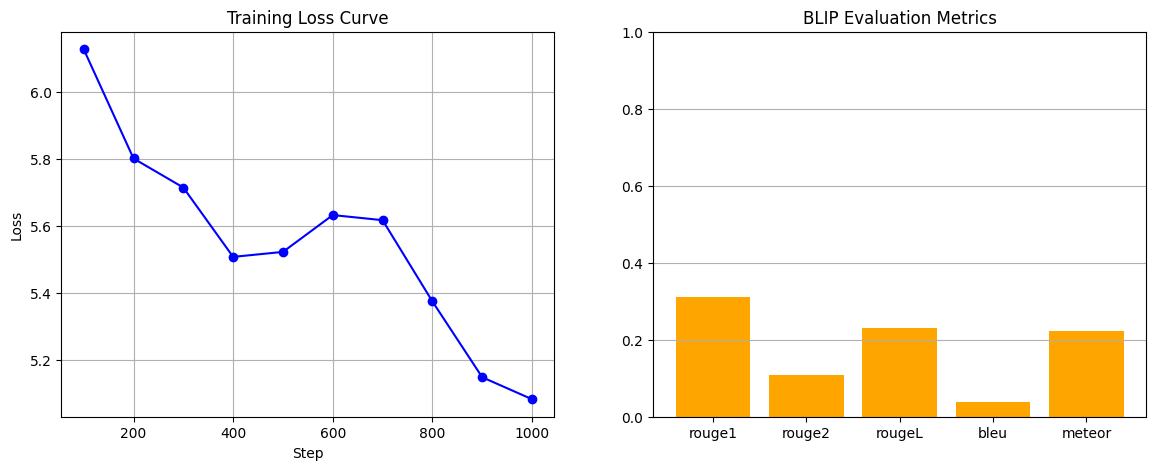

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))

steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
losses = [6.1288, 5.8020, 5.7150, 5.5076, 5.5225, 5.6327, 5.6174, 5.3743, 5.1475, 5.0818]

# Loss curve
axs[0].plot(steps, losses, marker='o', color='blue')
axs[0].set_title("Training Loss Curve")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Loss")
axs[0].grid(True)

# Metrics
axs[1].bar(metrics.keys(), metrics.values(), color='orange')
axs[1].set_title("BLIP Evaluation Metrics")
axs[1].set_ylim(0,1)
axs[1].grid(axis='y')

plt.show()
